In [1]:
import numpy as np
from functools import partial
from tensorflow.keras.metrics import MeanMetricWrapper
import pickle
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import random
from tensorflow.image import psnr, ssim # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import astra   # 导入astra
astra.test()   # 进行测试

ASTRA Toolbox v2.3.1
Getting GPU info... GPU #0: NVIDIA GeForce RTX 3060 Laptop GPU, with 6143MB, CUDA compute capability 8.6
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


In [ ]:
class AstraProjector:
    def __init__(self, image_size=128, num_angles=90, projector_type='cuda'):
        import astra
        self.astra = astra
        self.image_size = image_size
        self.num_angles = num_angles
        self.projector_type = projector_type
        #astra几何设置
        self.vol_geom = self.astra.create_vol_geom(image_size, image_size)
        self.angles = np.linspace(0, np.pi, num_angles, endpoint=False)
        self.proj_geom = self.astra.create_proj_geom('parallel', 1.0, image_size, self.angles)
        self.projector_id = self.astra.create_projector(projector_type, self.proj_geom, self.vol_geom)

    def forward(self, img):
        #前向投影(X)
        vol_id = self.astra.data2d.create('-vol', self.vol_geom, img)
        sino_id = self.astra.data2d.create('-sino', self.proj_geom)
        cfg = {
            'type': 'FP_CUDA' if 'cuda' in self.projector_type else 'FP',
            'ProjectorId': self.projector_id,
            'VolumeDataId': vol_id,
            'ProjectionDataId': sino_id
        }
        alg_id = self.astra.algorithm.create(cfg)
        self.astra.algorithm.run(alg_id)
        sino = self.astra.data2d.get(sino_id)

        self.astra.algorithm.delete(alg_id)
        self.astra.data2d.delete([vol_id, sino_id])
        return sino

    def backproject(self, sino):
        #直接反投影（X'）
        sino_id = self.astra.data2d.create('-sino', self.proj_geom, sino)
        rec_id = self.astra.data2d.create('-vol', self.vol_geom)
        cfg = {
            'type': 'BP_CUDA' if 'cuda' in self.projector_type else 'BP',
            'ProjectorId': self.projector_id,
            'ProjectionDataId': sino_id,
            'ReconstructionDataId': rec_id
        }
        alg_id = self.astra.algorithm.create(cfg)
        self.astra.algorithm.run(alg_id)
        recon = self.astra.data2d.get(rec_id)

        self.astra.algorithm.delete(alg_id)
        self.astra.data2d.delete([sino_id, rec_id])
        return recon

    def fbp(self, sino):
        #滤波反投影（FBP）
        sino_id = self.astra.data2d.create('-sino', self.proj_geom, sino)
        rec_id = self.astra.data2d.create('-vol', self.vol_geom)
        cfg = self.astra.astra_dict('FBP_CUDA' if 'cuda' in self.projector_type else 'FBP')
        cfg['ProjectionDataId'] = sino_id
        cfg['ReconstructionDataId'] = rec_id
        cfg['ProjectorId'] = self.projector_id
        alg_id = self.astra.algorithm.create(cfg)
        self.astra.algorithm.run(alg_id)
        recon = self.astra.data2d.get(rec_id)

        self.astra.algorithm.delete(alg_id)
        self.astra.data2d.delete([sino_id, rec_id])
        return recon

    def data_gradient(self, resid):
        '''grad = X'(Xf - g)'''
        return self.backproject(resid)

    def __del__(self):
        self.astra.projector.delete(self.projector_id)



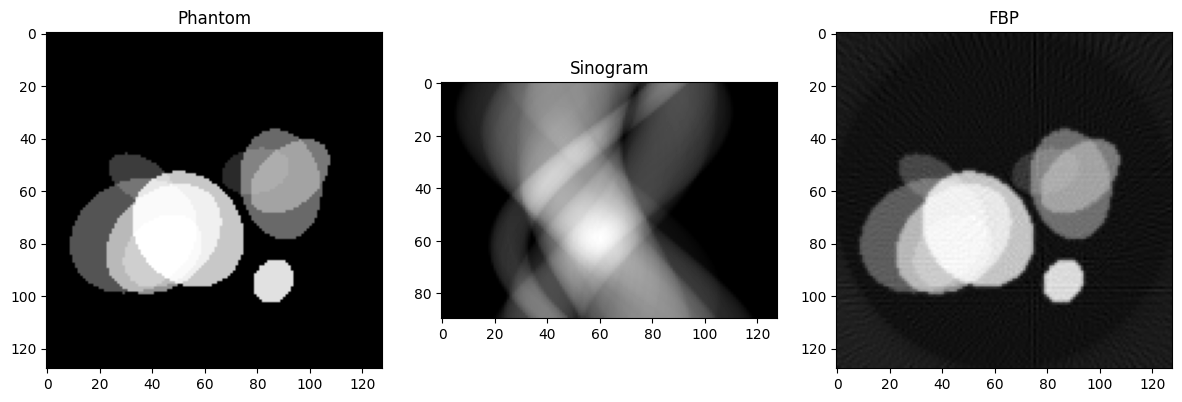

In [ ]:
# 参数
image_size = 128
num_angles = 90
angles = np.linspace(0, np.pi, num_angles, endpoint=False).astype(np.float32)

# ASTRA 几何配置
projector = AstraProjector(image_size=128, num_angles=90)

# 椭圆图像生成器
def generate_phantom():
    img = np.zeros((image_size, image_size), dtype=np.float32)
    for _ in range(np.random.randint(8, 12)):
        a, b = np.random.uniform(0.1, 0.4, 2)
        angle = np.random.uniform(0, np.pi)
        x0, y0 = np.random.uniform(-0.5, 0.5, 2)

        rr, cc = np.ogrid[:image_size, :image_size]
        x = (cc - image_size / 2) / (image_size / 2)
        y = (rr - image_size / 2) / (image_size / 2)
        ellipse = (((x - x0) * np.cos(angle) + (y - y0) * np.sin(angle))**2 / a**2 +
                   ((x - x0) * np.sin(angle) - (y - y0) * np.cos(angle))**2 / b**2) <= 1

        intensity = np.random.uniform(0.2, 1.0)
        alpha = np.random.uniform(0.3, 0.8)
        img[ellipse] = alpha * intensity + (1 - alpha) * img[ellipse]

    return np.clip(img, 0, 1)


# 投影与FBP
# 定义ASTRA投影工具
forward_astra = projector.forward
fbp_astra = projector.fbp
grad_astra = projector.data_gradient


# 可视化示例
phantom = generate_phantom()
sinogram = forward_astra(phantom)
reconstruction = fbp_astra(sinogram)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title('Phantom'); plt.imshow(phantom, cmap='gray')
plt.subplot(1, 3, 2); plt.title('Sinogram'); plt.imshow(sinogram, cmap='gray')
plt.subplot(1, 3, 3); plt.title('FBP'); plt.imshow(reconstruction, cmap='gray')
plt.tight_layout(); plt.show()


In [6]:
def generate_dataset(num_samples=1000, sigma=0.01, save_path='ct_dataset.pkl'):
    data = []
    for _ in range(num_samples):
        phantom = generate_phantom()# 128 * 128
        sino = forward_astra(phantom)# 90 * 128

        # 添加高斯噪声
        noisy_sino = sino + np.random.normal(loc=0.0, scale=sigma, size=sino.shape).astype(np.float32)

        data.append((phantom, noisy_sino))
    with open(save_path, 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved {num_samples} samples with noise sigma={sigma}")


In [ ]:
#生成数据集
#generate_dataset() 

Saved 1000 samples with noise sigma=0.01


In [7]:
# 加载 .pkl 数据集
with open('ct_dataset.pkl', 'rb') as f:
    data = pickle.load(f)  # List of (phantom, sinogram)

# 拆成 phantom 和 sinogram
phantoms = np.stack([d[0] for d in data], axis=0).astype(np.float32)[..., np.newaxis]#将所有2维图像堆叠为3维图像集合，并增加通道数（灰度图像通道数为1） 1000 * 128 * 128 * 1
sinograms = np.stack([d[1] for d in data], axis=0).astype(np.float32)[..., np.newaxis]#1000 * 90 * 128 * 1

# 数据划分
num_total = len(phantoms)
split = int(num_total * 0.8) #train : 800, validation : 200
train_phis, val_phis = phantoms[:split], phantoms[split:]
train_sinos, val_sinos = sinograms[:split], sinograms[split:]

In [8]:
def make_dataset(sinos, phantoms, batch_size=4, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((sinos, phantoms))#tf.dataset 其中元素为(sino, phantoms)
    if shuffle:
        ds = ds.shuffle(500)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)#按batch size打包,并开启预加载
    return ds

train_ds = make_dataset(train_sinos, train_phis)
val_ds   = make_dataset(val_sinos, val_phis, shuffle=False)

In [9]:
def batch_fbp(sinograms):
    #批量计算FBP
    return tf.map_fn(
        lambda x: tf.numpy_function(fbp_astra, [x], tf.float32),
        sinograms,
        dtype=tf.float32
    )


In [10]:
def batch_forward(f_prev):
    #批量计算前向投影
    return tf.map_fn(
        lambda x: tf.numpy_function(forward_astra, [x], tf.float32),
        f_prev,
        dtype=tf.float32
    )


In [11]:
def batch_gradient(residuals):
    """
    residuals: Tensor of shape (batch, num_angles, det_size)
    return: Tensor of shape (batch, image_size, image_size)
    """
    return tf.map_fn(
        lambda x: tf.numpy_function(grad_astra, [x], tf.float32),
        residuals,
        dtype=tf.float32
    )


In [14]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, sino, f_prev):
        # 1) 前向投影 + 残差
        proj = batch_forward(tf.squeeze(f_prev, -1))  # shape: (B, 90, 128)

        resid = proj - tf.squeeze(sino, axis=-1)

        # 2) 反投影梯度
        grad_data = batch_gradient(resid)

        # 3) TV 正则梯度
        #-∇·(∇f / (|∇f| + \epsilon))
        #使用sobel卷积核近似梯度
        epsilon = 1e-4
        sobel = tf.image.sobel_edges(f_prev)# shape: (B, H, W, 1, 2)
        gx, gy = sobel[...,0], sobel[...,1]# 获取 ∂x 和 ∂y 分量
        grad_mag = tf.sqrt(gx**2 + gy**2 + epsilon)
        norm_gx = gx / grad_mag
        norm_gy = gy / grad_mag
        div_x = tf.image.sobel_edges(norm_gx)[...,0]# ≈ ∂/∂x (∂f/∂x)
        div_y = tf.image.sobel_edges(norm_gy)[...,1]# ≈ ∂/∂y (∂f/∂y)
        grad_reg = -(div_x + div_y)

        # 4) 归一化
        def minmax(t):
            mn = tf.reduce_min(t, axis=[1,2,3], keepdims=True)
            mx = tf.reduce_max(t, axis=[1,2,3], keepdims=True)
            return (t - mn) / (mx - mn + 1e-8)

        f_prev_n    = minmax(f_prev)
        grad_data_n = minmax(tf.expand_dims(grad_data, -1))
        grad_reg_n  = minmax(grad_reg)

        # 5) 拼接
        stacked = tf.concat([f_prev_n, grad_data_n, grad_reg_n], axis=-1)

        return tf.ensure_shape(stacked, (None, image_size, image_size, 3))





In [15]:
# 构建模型
def build_model(iterative=True, num_iters=5):
    inp = tf.keras.Input(shape=(num_angles, image_size, 1), name='sino')#90 * 128 * 1

    f0 = tf.keras.layers.Lambda(
        lambda s: tf.expand_dims(batch_fbp(tf.squeeze(s, -1)), axis=-1),
        name='init_fbp'
        )(inp)#使用Astra的fbp得到初始重建图像f0
    f0 = tf.ensure_shape(f0, (None, image_size, image_size, 1))

    def update_net(x):
        y = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
        y = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(y)
        y = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(y)
        out = tf.keras.layers.Conv2D(1, 3, activation='linear', padding='same')(y)
        return tf.ensure_shape(out, (None, image_size, image_size, 1))

    f = f0
    for i in range(num_iters):
        x = PreprocessLayer(name=f'prep_{i}')(inp, f)
        delta = update_net(x)
        f = tf.keras.layers.Add(name=f'add_{i}')([f, delta])

    '''out = tf.keras.layers.Lambda(
        lambda t: (t - tf.reduce_min(t)) / (tf.reduce_max(t) - tf.reduce_min(t) + 1e-8),
        name='norm_out')(f)'''

    return tf.keras.Model(inputs=inp, outputs=f)

#model = build_model()
#model.summary()


In [16]:
def ssim_loss(y_true, y_pred):
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def mixed_loss(y_true, y_pred, alpha=0.25):
    """
    alpha: 权重，越大越偏向 SSIM，越小越偏向 MSE
    """
    ssim_l = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    mse_l = tf.reduce_mean(tf.square(y_true - y_pred))
    return alpha * ssim_l + (1 - alpha) * mse_l

In [17]:
checkpoint_cb = ModelCheckpoint(
    filepath='best_model.h5',           # 保存文件名
    monitor='val_loss',                 # 监视 val_loss
    save_best_only=True,                # 只保留最佳模型
    save_weights_only=False,           # 只保存权重可以设为 True
    verbose=1
)

In [18]:
earlystop_cb = EarlyStopping(
    monitor='val_loss',      # 监控指标
    patience=5,              # 容忍 5 个 epoch 没有提升
    restore_best_weights=True,
    verbose=1
)

In [19]:
model = build_model(iterative=True, num_iters=5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
    loss=mixed_loss,
    metrics=[
        MeanMetricWrapper(partial(tf.image.psnr, max_val=1.0), name='psnr'),
        MeanMetricWrapper(partial(tf.image.ssim, max_val=1.0), name='ssim')
    ]
)

model.summary()


Instructions for updating:
Use fn_output_signature instead
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sino (InputLayer)              [(None, 90, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 init_fbp (Lambda)              None                 0           ['sino[0][0]']                   
                                                                                                  
 tf.ensure_shape (TFOpLambda)   (None, 128, 128, 1)  0           ['init_fbp[0][0]']               
                                                                                                  
 prep_0 (PreprocessLayer)       (No

In [20]:
# 模型训练
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    #callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/20
200/200 [==============================] - 35s 138ms/step - loss: 0.0954 - psnr: 29.6686 - ssim: 0.6237 - val_loss: 0.0538 - val_psnr: 32.0907 - val_ssim: 0.7868
Epoch 2/20
200/200 [==============================] - 26s 131ms/step - loss: 0.0525 - psnr: 32.7733 - ssim: 0.7918 - val_loss: 0.0509 - val_psnr: 33.1146 - val_ssim: 0.7979
Epoch 3/20
200/200 [==============================] - 26s 129ms/step - loss: 0.0476 - psnr: 33.3526 - ssim: 0.8110 - val_loss: 0.0457 - val_psnr: 33.6816 - val_ssim: 0.8185
Epoch 4/20
200/200 [==============================] - 25s 126ms/step - loss: 0.0340 - psnr: 34.0437 - ssim: 0.8652 - val_loss: 0.0272 - val_psnr: 34.2680 - val_ssim: 0.8925
Epoch 5/20
200/200 [==============================] - 25s 127ms/step - loss: 0.0304 - psnr: 34.2755 - ssim: 0.8797 - val_loss: 0.0282 - val_psnr: 34.3443 - val_ssim: 0.8883
Epoch 6/20
200/200 [==============================] - 27s 133ms/step - loss: 0.0338 - psnr: 34.2258 - ssim: 0.8662 - val_loss: 0.0246 -

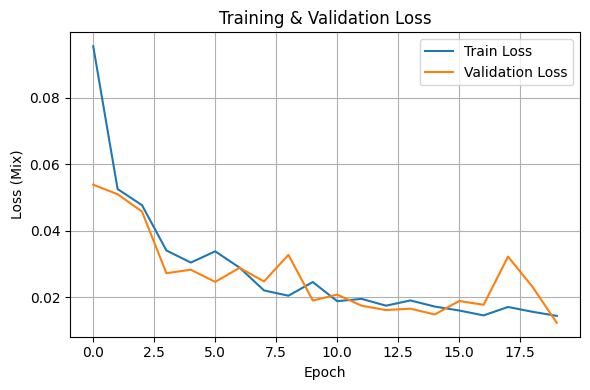

In [21]:
# 可视化损失曲线

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (Mix)")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
val_sino = val_sinos[0:1]      # shape (1, 90, 128, 1)
val_gt = val_phis[0,...,0]     # shape (128, 128)


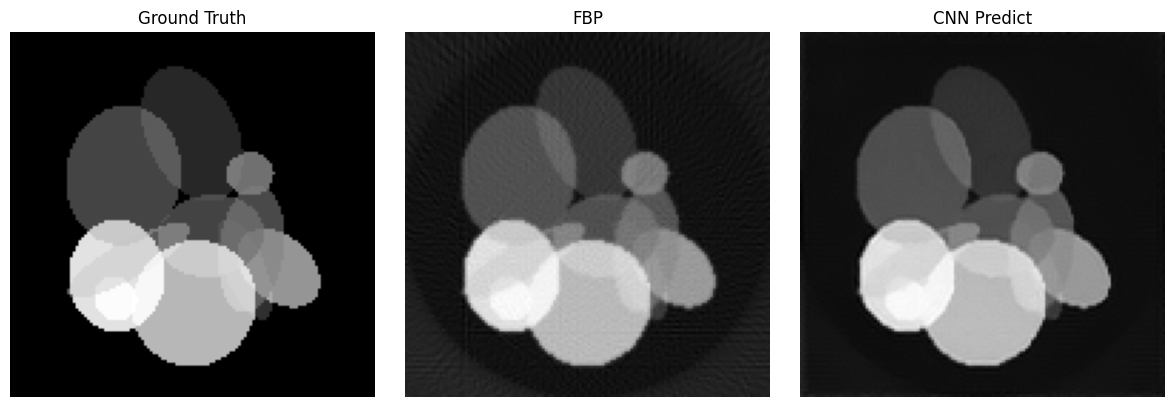

In [23]:
pred = model.predict(val_sino)[0,...,0]
fbp = fbp_astra(np.squeeze(val_sino[0,...,0]))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Ground Truth")
plt.imshow(val_gt, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("FBP")
plt.imshow(fbp, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("CNN Predict")
plt.imshow(pred, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#随机生成50张作为测试
test_phantoms = []
test_sinos = []

for _ in range(50):
    phantom = generate_phantom()
    sino = forward_astra(phantom)
    test_phantoms.append(phantom)
    test_sinos.append(sino)

test_phantoms = np.array(test_phantoms, dtype=np.float32)[..., np.newaxis]
test_sinos = np.array(test_sinos, dtype=np.float32)[..., np.newaxis]


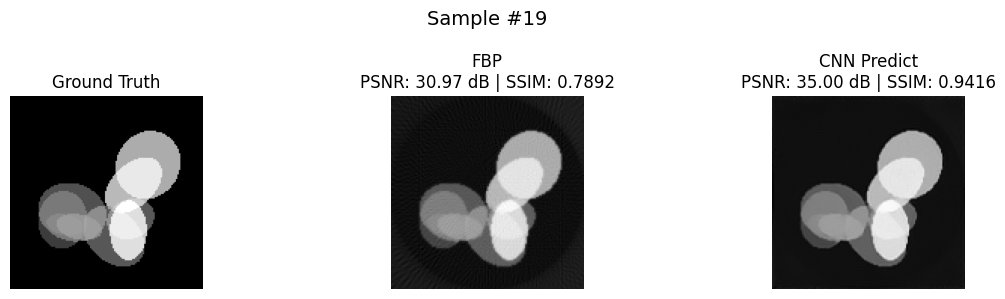

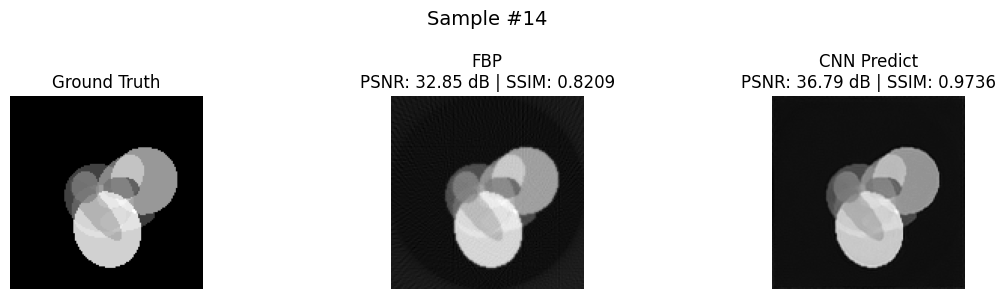

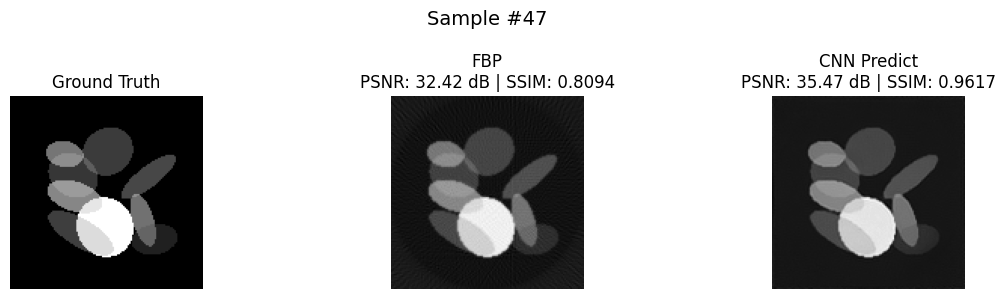

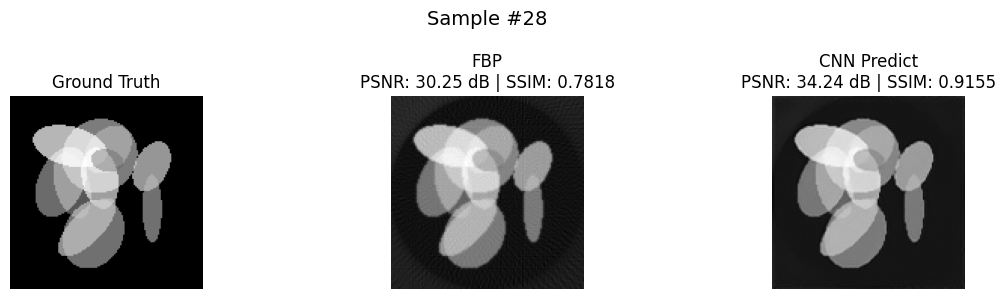

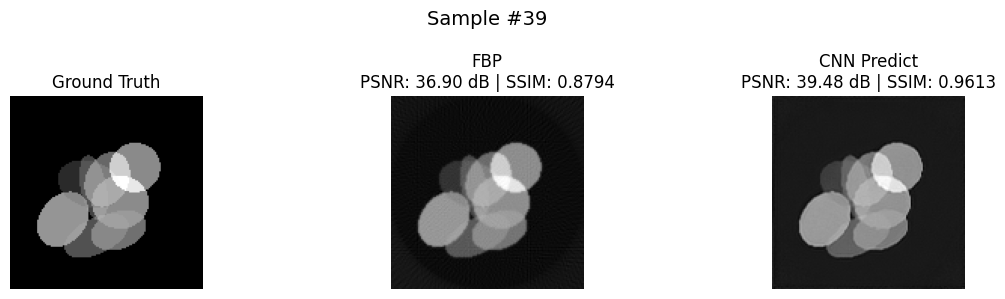

In [25]:

idxs = random.sample(range(50), 5)

for i, idx in enumerate(idxs):
    sino = test_sinos[idx:idx+1]
    gt = test_phantoms[idx,...,0]
    pred = model.predict(sino)[0,...,0]
    fbp  = fbp_astra(np.squeeze(sino[0,...,0]))

    # 计算 PSNR / SSIM
    psnr_fbp = psnr(gt[np.newaxis, ..., np.newaxis], fbp[np.newaxis, ..., np.newaxis], max_val=1.0).numpy()[0]
    ssim_fbp = ssim(gt[np.newaxis, ..., np.newaxis], fbp[np.newaxis, ..., np.newaxis], max_val=1.0).numpy()[0]
    psnr_cnn = psnr(gt[np.newaxis, ..., np.newaxis], pred[np.newaxis, ..., np.newaxis], max_val=1.0).numpy()[0]
    ssim_cnn = ssim(gt[np.newaxis, ..., np.newaxis], pred[np.newaxis, ..., np.newaxis], max_val=1.0).numpy()[0]

    # 显示图像
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Sample #{idx}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    plt.imshow(gt, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"FBP\nPSNR: {psnr_fbp:.2f} dB | SSIM: {ssim_fbp:.4f}")
    plt.imshow(fbp, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"CNN Predict\nPSNR: {psnr_cnn:.2f} dB | SSIM: {ssim_cnn:.4f}")
    plt.imshow(pred, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


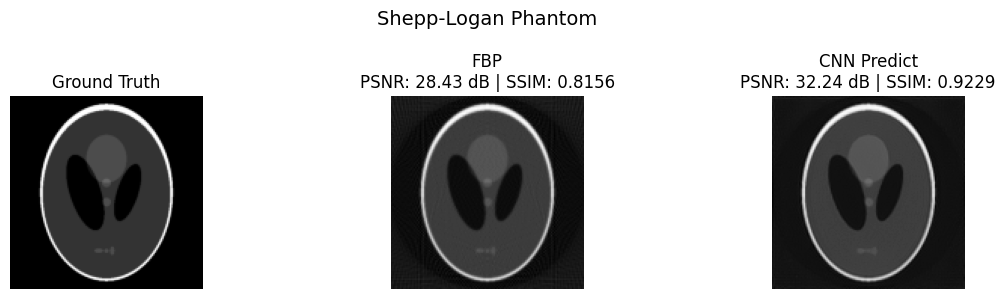

In [26]:
sl = shepp_logan_phantom()
sl = resize(sl, (image_size, image_size), anti_aliasing=True).astype(np.float32)
sl_sino = forward_astra(sl)
sl_pred = model.predict(sl_sino[np.newaxis, ..., np.newaxis])[0,...,0]
sl_fbp = fbp_astra(sl_sino)

# PSNR / SSIM
psnr_sl_fbp = psnr(sl[np.newaxis, ..., np.newaxis], sl_fbp[np.newaxis, ..., np.newaxis], max_val=1.0).numpy()[0]
ssim_sl_fbp = ssim(sl[np.newaxis, ..., np.newaxis], sl_fbp[np.newaxis, ..., np.newaxis], max_val=1.0).numpy()[0]
psnr_sl_cnn = psnr(sl[np.newaxis, ..., np.newaxis], sl_pred[np.newaxis, ..., np.newaxis], max_val=1.0).numpy()[0]
ssim_sl_cnn = ssim(sl[np.newaxis, ..., np.newaxis], sl_pred[np.newaxis, ..., np.newaxis], max_val=1.0).numpy()[0]

# 可视化
plt.figure(figsize=(12, 3))
plt.suptitle("Shepp-Logan Phantom", fontsize=14)

plt.subplot(1, 3, 1)
plt.title("Ground Truth")
plt.imshow(sl, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"FBP\nPSNR: {psnr_sl_fbp:.2f} dB | SSIM: {ssim_sl_fbp:.4f}")
plt.imshow(sl_fbp, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f"CNN Predict\nPSNR: {psnr_sl_cnn:.2f} dB | SSIM: {ssim_sl_cnn:.4f}")
plt.imshow(sl_pred, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

